In [12]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200

## Exercise 4 {-}

We begin by defining the rhs of the ODE:

In [2]:
def f(u,t=0):
    u1, u2 = u[:,0], u[:,1]
        
    return np.array([u1 - u1*u2, u1*u2 - u2]).T

We also define a function that generates uniform samples from the square `u0bar` + [-`delta`, `delta`]${}^2$.

In [3]:
def generate_u0(u0bar, delta, N=1):
    u0 = u0bar + np.random.uniform(-delta,delta,size=(N,2))
    return np.squeeze(u0)

### (a) Basic MLMC {-}

In [4]:
u0bar = np.array([0.5,2])
delta = 0.2
T     = 6

def euler_helper(u0,h,T):
    res = np.atleast_2d(u0).copy()
    timesteps = int(np.floor(T / h))
    for _ in range(timesteps):
        res += h*f(res)
    return res

def mlmc_euler(Nl, hl):
    means = np.zeros((len(Nl),))
    variances = np.zeros_like(means)

    # Treat 1st case separately
    u0 = generate_u0(u0bar, delta, Nl[0])
    qoi = euler_helper(u0, hl[0], T)[:,0]
    means[0] = np.mean(qoi)
    variances[0] = np.var(qoi)
    
    for i, N in enumerate(Nl[1:],1):
        u0 = generate_u0(u0bar, delta, N)
        q1 = euler_helper(u0, hl[i], T)[:,0]
        q2 = euler_helper(u0, hl[i-1], T)[:,0]
        q = q1 - q2
        means[i] = np.mean(q)
        variances[i] = np.var(q)
        
    return np.sum(means), means, variances

In [5]:
res,_,_ = mlmc_euler([100000, 10000, 1000, 100, 50, 10], [0.1, 0.05, 0.01, 0.001, 0.0002, 0.0001])

### (b) Adaptive MLMC {-}

Below we implement the adaptive algorithm as discussed in the lecture. In addition to the tolerance, the algorithm expects a value for the initial number of MC samples and an initial step size. The parameter `m` is used to compute the step sizes on the smaller levels.

In [6]:
def mlmc_adaptive(tol, Ninit, hinit, m=2):
    Nl = [Ninit, Ninit]
    
    ytol = (0.9*m-1)/np.sqrt(2)*tol
    
    maxit = 100
    while maxit > 0:
        maxit -= 1
        
        hl = [hinit / m**k for k in range(len(Nl))]
        
        res, ys, vars = mlmc_euler(Nl, hl)
        costs = [N/h for (N,h) in zip(Nl,hl)]
        
        N_factor = 2/(tol**2)*np.sum(np.sqrt(np.multiply(vars, costs)))
        Nl = [int(N_factor*np.sqrt(V/C)) for V,C in zip(vars,costs)]
        
        if (np.abs(ys[-1]) > ytol) or (np.sum(np.divide(vars, Nl)) <= tol**2/2):
            Nl = np.append(Nl, Ninit)
        else:
            return res, ys, vars, costs, Nl, hl        

In [7]:
res, ys, vars, costs, NL, hL = mlmc_adaptive(0.005, 1000, 0.2, 2)

For the exemplar run from above, the algorithm generated the following numbers for $N_l$:

In [8]:
NL

[52688, 19811, 12045, 5400, 2622, 1209, 584, 384, 58]

### (c) Numerically observed rates {-}

Below, we study the quality of the estimator; in particular, we check if we observe the theoretically derived rates.

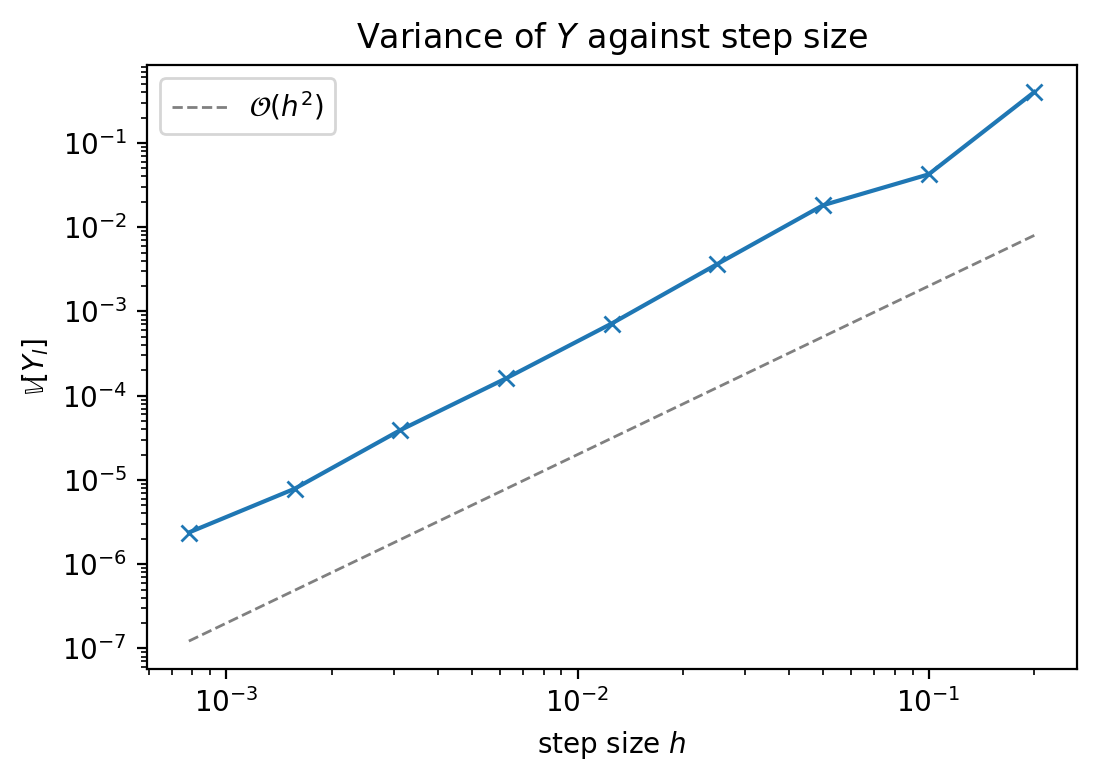

In [13]:
plt.loglog(hL, vars, '-x')
plt.xlabel("step size $h$")
plt.ylabel("$\mathbb{V}[Y_l]$")
plt.title("Variance of $Y$ against step size")
x0 = hL[0]
x1 = hL[-1]
y = lambda x : 0.2*x**2
y0 = y(x0)
y1 = y(x1)

plt.loglog([x0,x1], [y0,y1], '--', color='gray', linewidth=1, label="$\mathcal{O}(h^2)$")
plt.legend()
plt.show();

This plot corresponds to (M2) in the MLMC complexity theorem, i.e., here we plot the rate $\beta$. We indeed observe a rate of $\beta = 2$.

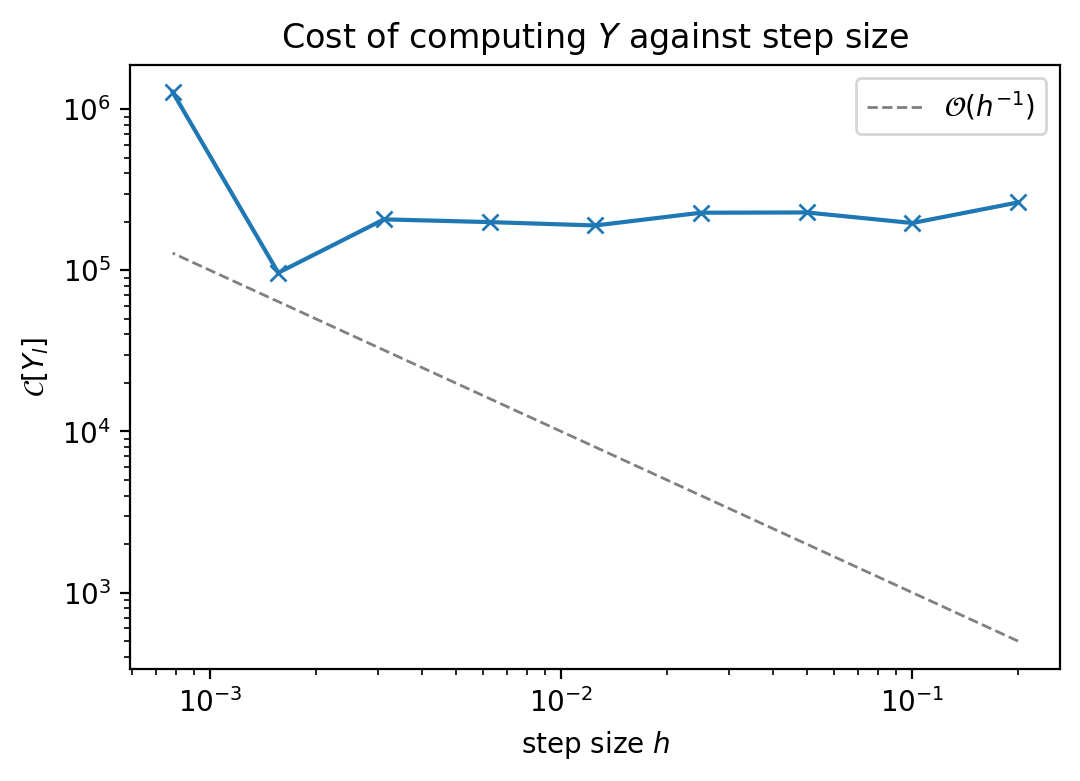

In [14]:
plt.loglog(hL, costs, '-x')
plt.xlabel("step size $h$")
plt.ylabel("$\mathcal{C}[Y_l]$")
plt.title("Cost of computing $Y$ against step size")
x0 = hL[0]
x1 = hL[-1]
y = lambda x : 100*x**-1
y0 = y(x0)
y1 = y(x1)

plt.loglog([x0,x1], [y0,y1], '--', color='gray', linewidth=1, label="$\mathcal{O}(h^{-1})$")
plt.legend()
plt.show();

For some reason, we do not observe the expected rate of $\gamma = 1$.

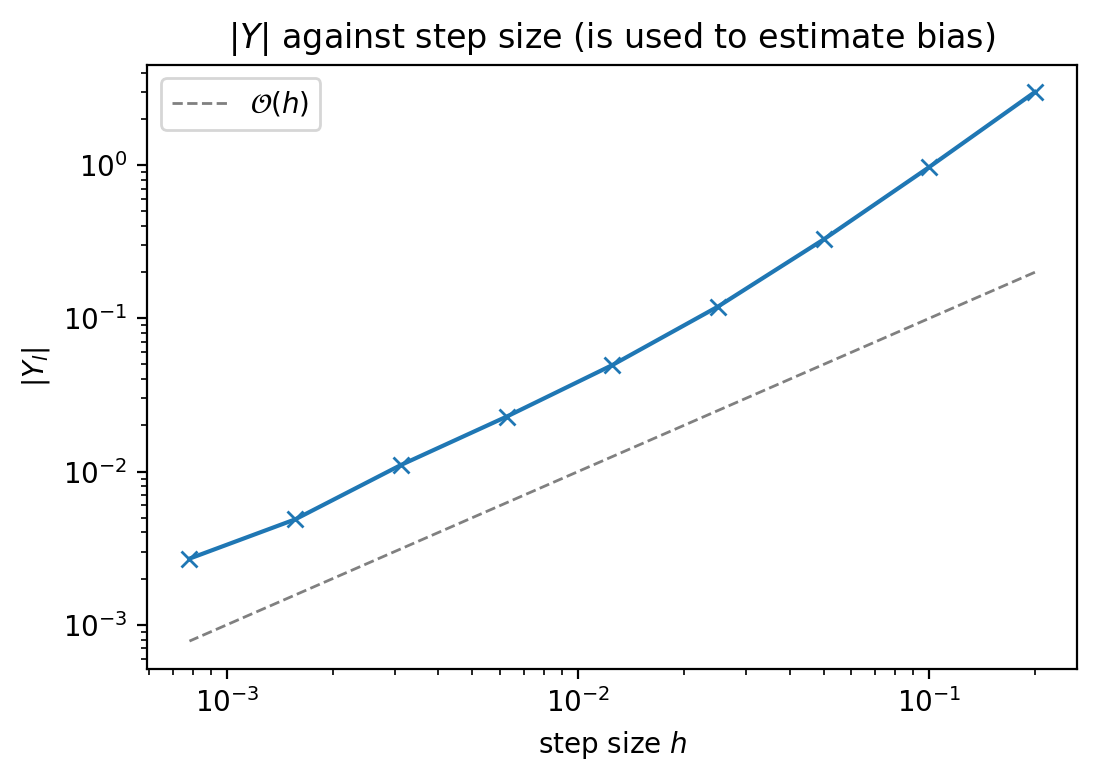

In [15]:
plt.loglog(hL, np.abs(ys), '-x')
plt.xlabel("step size $h$")
plt.ylabel("$|Y_l|$")
plt.title("$|Y|$ against step size (is used to estimate bias)")
x0 = hL[0]
x1 = hL[-1]
y = lambda x : x
y0 = y(x0)
y1 = y(x1)

plt.loglog([x0,x1], [y0,y1], '--', color='gray', linewidth=1, label="$\mathcal{O}(h)})$")
plt.legend()
plt.show();

Here, we observe again the expected rate of $\alpha = 1$ (this now corresponds to (M1) in the theorem).